# Quantitative Stability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mergeTrees import *

### Creating a density on the circle

The following creates a particular density on the circle with two modes, arranged symmetrically. This will serve as a running synthetic example for the rest of the notebook.

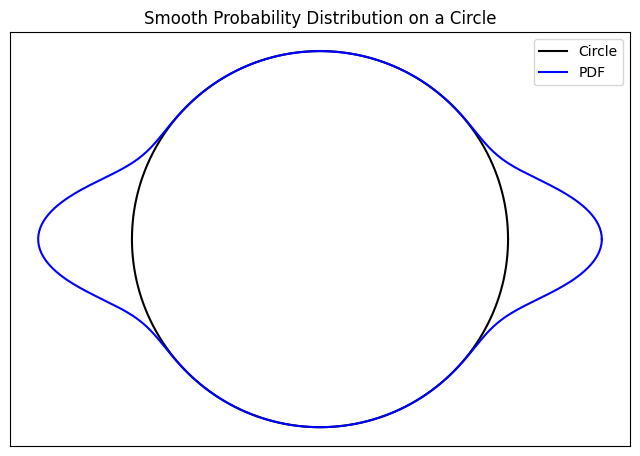

In [28]:
def smooth_circular_distribution(theta):
    """
    Define a smooth probability density function over the circle.
    Args:
        theta: Angle in radians (array-like).

    Returns:
        PDF values corresponding to each theta.
    """
    # Example: A Gaussian-like bump on the circle centered at theta=pi
    return np.exp(-0.5 * ((theta - np.pi) % (2 * np.pi) - np.pi)**2 / 0.2**2) + np.exp(-0.5 * ((theta) % (2 * np.pi) - np.pi)**2 / 0.2**2)

# Generate angles for the circle
angles = np.linspace(0, 2 * np.pi, 1000)
sparse_angles = np.linspace(0,2*np.pi,500)

# Evaluate the PDF
pdf_values = smooth_circular_distribution(angles)

# Normalize the PDF
pdf_values /= np.trapz(pdf_values, angles)  # Ensure integral over the circle is 1

# Convert PDF values to Cartesian coordinates
x_circle = np.cos(angles)
y_circle = np.sin(angles)

x_pdf = (1 + pdf_values/2) * np.cos(angles)
y_pdf = (1 + pdf_values/2) * np.sin(angles)

# Plot the circle and the PDF
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
plt.title("Smooth Probability Distribution on a Circle")
plt.gca().set_aspect("equal", adjustable="box")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()


### Sampling points from the distribution

We want to study the behavior of the Fréchet mean when we empirically approximate the distribution.

This function samples angles from the given pdf on the circle.

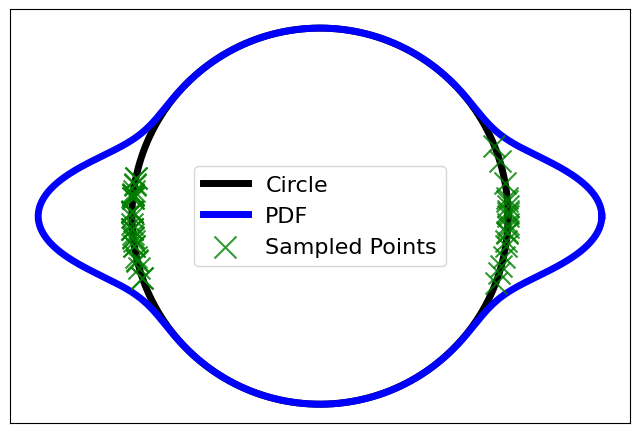

In [90]:
# Sample points from the distribution on the circle
def sample_points_from_distribution(n, angles, pdf_values, random_seed = None):
    """
    Sample n points from the given probability distribution on the circle.

    Args:
        n: Number of points to sample.
        angles: Array of angles (in radians).
        pdf_values: Array of PDF values corresponding to the angles.

    Returns:
        Sampled points as (x, y) coordinates.
    """
    # Normalize PDF for use as probabilities
    probabilities = pdf_values / np.sum(pdf_values)

    # Sample angles based on the distribution
    if random_seed is None:
        sampled_indices = np.random.choice(list(range(len(angles))), size=n, p=probabilities)
        sampled_angles = angles[sampled_indices]
    else:
        rng = np.random.RandomState(random_seed)
        sampled_indices = rng.choice(list(range(len(angles))), size=n, p=probabilities)
        sampled_angles = angles[sampled_indices]

    # Convert sampled angles to circle coordinates
    x_samples = np.cos(sampled_angles)
    y_samples = np.sin(sampled_angles)

    return sampled_indices, sampled_angles, x_samples, y_samples

# Example #
n_samples = 50
sampled_indices, sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)

# Plot the sampled points #
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black",linewidth=5)  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue",linewidth=5)  # PDF superimposed
plt.scatter(x_samples, y_samples, color="green", s=250, marker="x", label="Sampled Points", alpha=0.8,zorder=10)  # Adjusted marker and size
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal", adjustable="box")
plt.legend(fontsize=16)
plt.savefig('CircleSamples.png',format='png',dpi=300)
plt.show()

## Functions for the Experiment

Circular Fréchet mean and related functions.

In [30]:
def circular_distance(angle1,angle2):

    # angle1 and angle2 should be between 0 and 2pi

    first_distance = np.abs(angle1-angle2)
    second_distance = 2*np.pi-first_distance

    return min([first_distance,second_distance])

In [31]:
def circular_frechet_function(angle,sampled_angles,p=2):

    distances = [circular_distance(angle,sampled_angle) for sampled_angle in sampled_angles]
    frechet_value = np.sum([distance**p for distance in distances])

    return frechet_value

In [32]:
def shift_angles(angle,sampled_angles):

    shifted = []
    for sampled_angle in sampled_angles:
        if sampled_angle > angle:
            shifted.append(sampled_angle - angle)
        else:
            shifted.append(sampled_angle - angle + 2*np.pi)

    return shifted

In [33]:
def circular_frechet_mean(angles,sampled_angles):

    frechet_mean = 0
    # print_indicator = False
    
    for angle in angles:
        # if print_indicator:
        #     print('angle:',angle,'current frechet mean:',frechet_mean)
        shifted = shift_angles(angle,sampled_angles)
        mean = (np.mean(shifted) + angle)%(2*np.pi)
        if circular_frechet_function(mean,sampled_angles) < circular_frechet_function(frechet_mean,sampled_angles):
            frechet_mean = mean
            print_indicator = True
        # else:
        #     print_indicator = False
    
    return frechet_mean

#### Circular Wasserstein Distances

This is code to compute the 2-Wasserstein distance between two discrete uniform distributions on the circle with the same number of support points. 

In [34]:
def one_d_Wasserstein(supp1,supp2):

    # Assumes uniform discrete measures with the same number of points
    
    supp1_sorted = np.array(sorted(supp1))
    supp2_sorted = np.array(sorted(supp2))

    return np.linalg.norm(supp1_sorted-supp2_sorted)

In [35]:
def circular_Wasserstein(angles,sampled_angles1,sampled_angles2):

    dist = 1e6
    n = len(sampled_angles1)
    
    for angle in angles:
        shifted1 = shift_angles(angle,sampled_angles1)
        shifted2 = shift_angles(angle,sampled_angles2)
        wass_dist = one_d_Wasserstein(shifted1,shifted2)
        if wass_dist < dist:
            dist = wass_dist

    return dist/np.sqrt(n)

### Experiment

In [36]:
G = nx.Graph()
G.add_nodes_from(list(range(len(angles))))
G.add_edges_from([(i,i+1) for i in range(len(angles)-1)])
G.add_edge(len(angles)-1,0)

In [64]:
ns = [10,25,50,100,250,500,1000]
num_trials = 50

frechet_means_all_trials = []
wasserstein_distances_all_trials = []
merge_trees_all_trials = []
sampled_indices_all_trials = []

for n in ns:
    print('n=',n)
    n_samples = n
    frechet_means = []
    wasserstein_distances = []
    all_sampled_angles = []
    merge_trees_this_trial = []
    sampled_indices_this_trial = []
    
    for j in range(num_trials):
        sampled_indices, sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)
        frechet_mean = circular_frechet_mean(sparse_angles,sampled_angles)
        sampled_indices_this_trial.append(sampled_indices)
        frechet_means.append(frechet_mean)
        all_sampled_angles.append(sampled_angles)
        
        deviation_values_sampled = np.array([
        np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
                for j in range(len(sampled_angles))]) ** (1/2) 
        for i in range(len(angles))])
        f = {i:deviation_values_sampled[i] for i in range(len(angles))}
        T = get_merge_tree(G,f)
        merge_trees_this_trial.append(T)

    for j in range(num_trials):
        for k in range(j+1,num_trials):
            dist = circular_Wasserstein(sparse_angles,all_sampled_angles[j],all_sampled_angles[k])
            wasserstein_distances.append(dist)

    wasserstein_distances_all_trials.append(wasserstein_distances)
    frechet_means_all_trials.append(frechet_means)
    merge_trees_all_trials.append(merge_trees_this_trial)
    sampled_indices_all_trials.append(sampled_indices_this_trial)

n= 10
n= 25
n= 50
n= 100
n= 250
n= 500
n= 1000


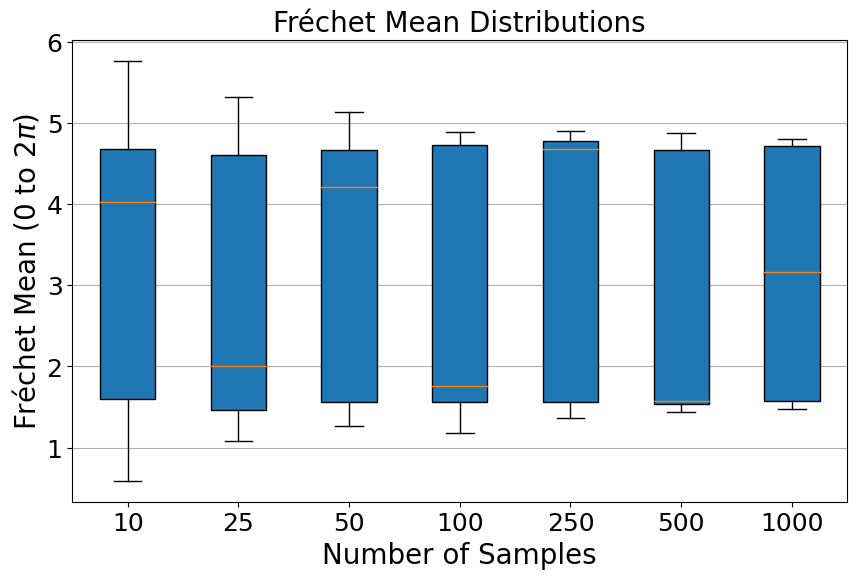

In [124]:
plt.figure(figsize=(10, 6))
plt.boxplot(frechet_means_all_trials, vert=True, patch_artist=True)
plt.xlabel("Number of Samples",fontsize=20)
plt.xticks(range(1, len(ns) + 1), ns)
plt.ylabel("Fréchet Mean (0 to 2$\pi$)",fontsize=20)
plt.title("Fréchet Mean Distributions",fontsize=20)
plt.grid(axis='y')
ax = plt.gca()
ax.tick_params(labelsize = 18)
plt.savefig("FrechetMeanDistributions.png",format='png',dpi=300)
plt.show()

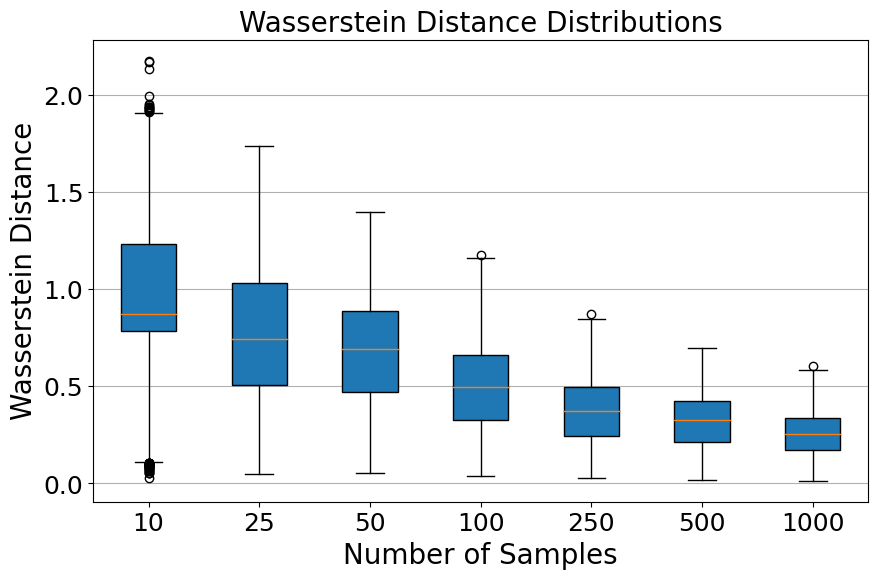

In [125]:
plt.figure(figsize=(10, 6))
plt.boxplot(wasserstein_distances_all_trials, vert=True, patch_artist=True)
plt.xlabel("Number of Samples",fontsize=20)
plt.xticks(range(1, len(ns) + 1), ns)
plt.ylabel("Wasserstein Distance",fontsize=20)
plt.title("Wasserstein Distance Distributions",fontsize=20)
plt.grid(axis='y')
ax = plt.gca()
ax.tick_params(labelsize = 18)
plt.savefig("WassersteinDistributions.png",format='png',dpi=300)
plt.show()

In [113]:
# for j in range(len(ns)):
#     # Plot the sampled points
#     plt.figure(figsize=(8, 8))
#     plt.plot(x_circle, y_circle, label="Circle", color="black")  # Circle outline
#     # plt.plot(x_pdf, y_pdf, label="PDF", color="blue")  # PDF superimposed
#     x_samples = [np.cos(f) for f in frechet_means_all_trials[j]]
#     y_samples = [np.sin(f) for f in frechet_means_all_trials[j]]
#     plt.scatter(x_samples, y_samples, color="red", s=400, marker="x", label="Sampled Points", alpha=0.8)  # Adjusted marker and size
#     # plt.title("Sampled Points from the Circular Distribution")
#     plt.gca().set_aspect("equal", adjustable="box")
#     plt.xticks([])
#     plt.yticks([])
#     # plt.legend()
#     plt.show()

### Merge Tree to Metric Measure Space

Given a merge tree $T$, we need to convert it into a metric measure space to apply the Gromov-Wasserstein distance.

First we compute pairwise distances between nodes.

In [68]:
def tree_to_distance_matrix(T):
    
    D = np.zeros([len(T),len(T)])
    
    for i,s in enumerate(T.nodes()):
        for j,t in enumerate(T.nodes()):
            D[i,j] = max([T.nodes[n]['height'] for n in nx.shortest_path(T,source=s,target=t)])-T.nodes[s]['height']
            
    return np.maximum(D,D.T)

Next, we need a function to assign a measure to the nodes of the merge tree.

The first function takes the sampled points from the pdf and produces an empirical measure on the circle.

In [69]:
def sampled_to_measure(angles,sampled_indices):
    
    pdf = np.zeros(len(angles))
    
    for idx in sampled_indices:
        pdf[idx] += 1
    
    pdf /= len(sampled_indices)
    
    return pdf

Next, we assign a measure to the nodes of the merge tree. This is a simple discrete approximation of the merge tree measure from the paper (i.e., the pushforward under the quotient map). 

In [70]:
def get_merge_tree_measure(T,pdf):
    
    node_list = [n for n in T.nodes()]
    mu = np.zeros(len(node_list))
    
    for i in range(len(node_list)):
        
        node = node_list[i]
        neighbors = [n for n in T.neighbors(node)]
        subset = T.nodes[node]['subset']
        
        for n in neighbors:
            if T.nodes[n]['height'] < T.nodes[node]['height']:
                subset = subset - T.nodes[n]['subset']

        mu[i] = np.sum(pdf[list(subset)])
        
    return mu

#### Testing

Let's test this on a merge tree from our experimental setup.

The next code block generates a merge tree via the scheme above and visualizes it.

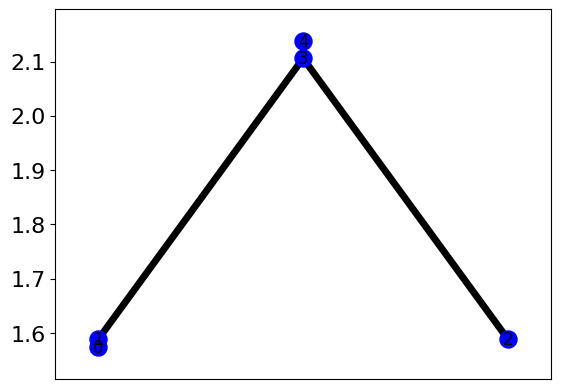

In [71]:
sampled_indices, sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)
deviation_values_sampled = np.array([
np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
        for j in range(len(sampled_angles))]) ** (1/2) 
for i in range(len(angles))])
f = {i:deviation_values_sampled[i] for i in range(len(angles))}

T= get_merge_tree(G,f)

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

nx.draw_networkx(T, pos=pos, with_labels=True,node_size = 150, node_color = 'blue',width = 5)
plt.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)

Now we generate the pairwise distance matrix:

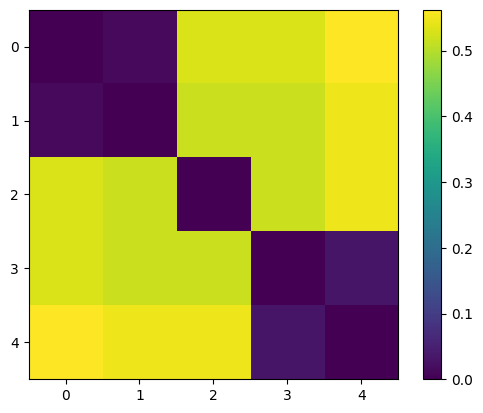

In [72]:
D = tree_to_distance_matrix(T)
plt.imshow(D)
plt.colorbar()
plt.show()

We also generate a measure on the merge tree nodes:

In [73]:
pdf = sampled_to_measure(angles,sampled_indices)
mu = get_merge_tree_measure(T,pdf)
print(mu)

[0.    0.    0.    0.703 0.297]


## Gromov-Wasserstein Distances Between Merge Trees

Finally, we compute distance distributions for the merge trees in our experiment, w.r.t. Gromov-Wasserstein distance.

In [74]:
import ot

In [75]:
gw_distances_all_trials = []

for i,n in enumerate(ns):
    
    gw_distances = []
    
    merge_tree_ensemble = merge_trees_all_trials[i]
    sampled_indices_ensemble = sampled_indices_all_trials[i]
    
    for j in range(num_trials):
        T1 = merge_tree_ensemble[j]
        D1 = tree_to_distance_matrix(T1)
        sampled_indices1 = sampled_indices_ensemble[j]
        pdf1 = sampled_to_measure(angles,sampled_indices1)
        mu1 = get_merge_tree_measure(T1,pdf1)
        
        for k in range(j+1,num_trials):
            T2 = merge_tree_ensemble[k]
            D2 = tree_to_distance_matrix(T2)
            sampled_indices2 = sampled_indices_ensemble[k]
            pdf2 = sampled_to_measure(angles,sampled_indices2)
            mu2 = get_merge_tree_measure(T2,pdf2)
            
            dist = ot.gromov.gromov_wasserstein2(D1,D2,p=mu1,q=mu2)
            gw_distances.append(dist)
            
    gw_distances_all_trials.append(gw_distances)

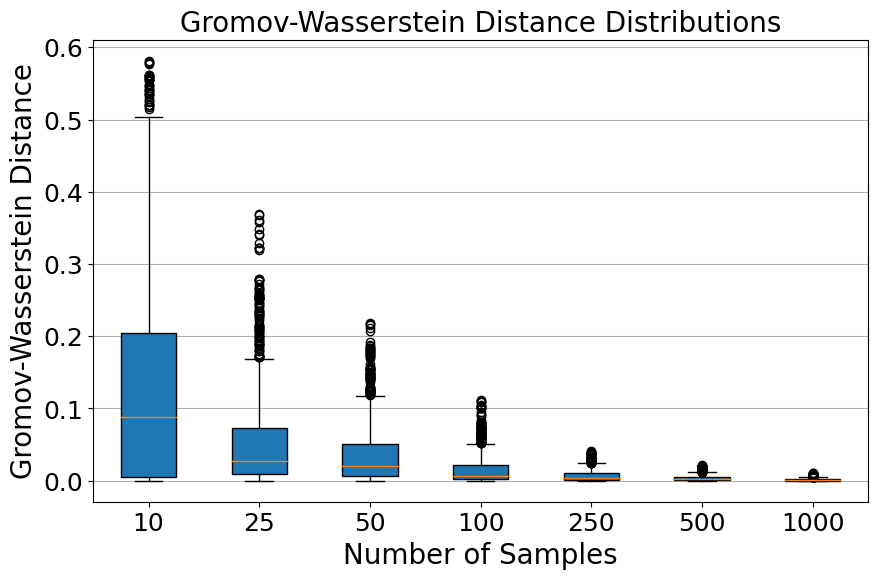

In [126]:
plt.figure(figsize=(10, 6))
plt.boxplot(gw_distances_all_trials, vert=True, patch_artist=True)
plt.xlabel("Number of Samples",fontsize=20)
plt.xticks(range(1, len(ns) + 1), ns)
plt.ylabel("Gromov-Wasserstein Distance",fontsize=20)
plt.title("Gromov-Wasserstein Distance Distributions",fontsize=20)
plt.grid(axis='y')
ax = plt.gca()
ax.tick_params(labelsize = 18)
plt.savefig("GromovWassersteinDistributions.png",format='png',dpi=300)
plt.show()

### Summary Figures

The following code generates the figures used in the summary graphic for the experiment.

In [96]:
n_samples = 50
sampled_indices, sampled_angles, x_samples, y_samples = sample_points_from_distribution(n_samples, angles, pdf_values)

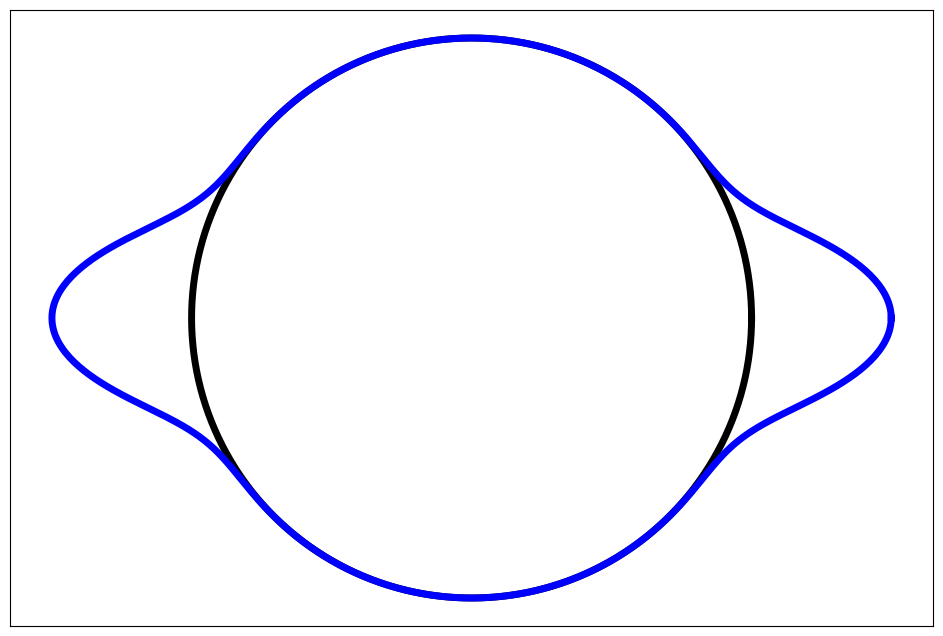

In [109]:
plt.figure(figsize=(12, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black",linewidth=5)  # Circle outline
plt.plot(x_pdf, y_pdf, label="PDF", color="blue",linewidth=5)  # PDF superimposed
# plt.scatter(x_samples, y_samples, color="green", s=250, marker="x", label="Sampled Points", alpha=0.8,zorder=10)  # Adjusted marker and size
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal", adjustable="box")
# plt.legend(fontsize=16)
plt.savefig('CircleDistribution.png',format='png',dpi=300)
plt.show()

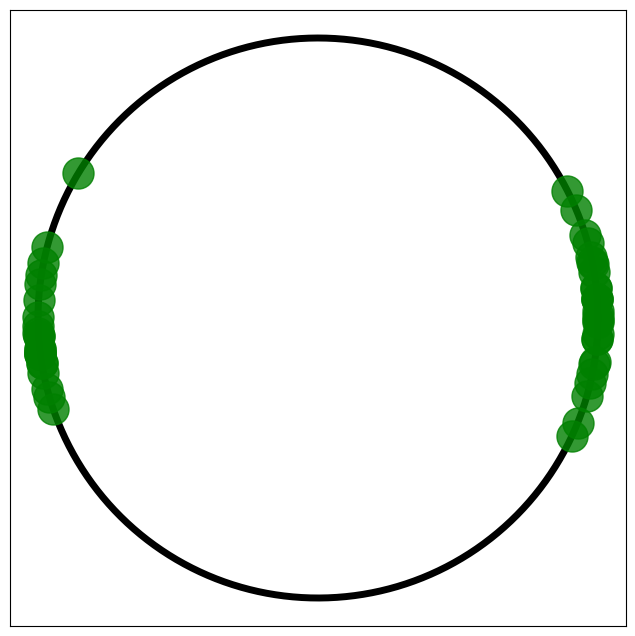

In [112]:
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black",linewidth=5)  # Circle outline
# plt.plot(x_pdf, y_pdf, label="PDF", color="blue",linewidth=5)  # PDF superimposed
plt.scatter(x_samples, y_samples, color="green", s=500, marker="o", label="Sampled Points", alpha=0.8,zorder=10)  # Adjusted marker and size
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal", adjustable="box")
# plt.legend(fontsize=16)
plt.savefig('CircleSamples.png',format='png',dpi=300)
plt.show()

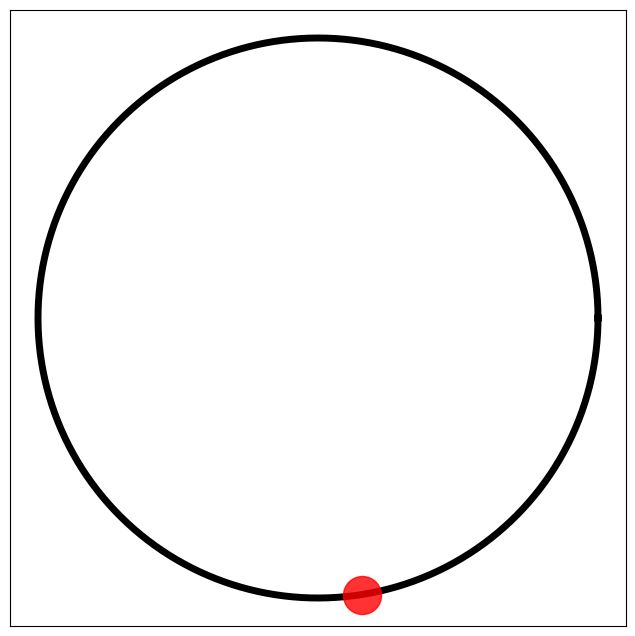

In [111]:
frechet_mean = circular_frechet_mean(sparse_angles,sampled_angles)
x_mean = np.cos(frechet_mean)
y_mean = np.sin(frechet_mean)
plt.figure(figsize=(8, 8))
plt.plot(x_circle, y_circle, label="Circle", color="black",linewidth=5)  # Circle outline
# plt.plot(x_pdf, y_pdf, label="PDF", color="blue",linewidth=5)  # PDF superimposed
plt.scatter(x_mean, y_mean, color="red", s=750, marker="o", label="Sampled Points", alpha=0.8,zorder=10)  # Adjusted marker and size
plt.xticks([])
plt.yticks([])
plt.gca().set_aspect("equal", adjustable="box")
# plt.legend(fontsize=16)
plt.savefig('CircleFrechetMean.png',format='png',dpi=300)
plt.show()

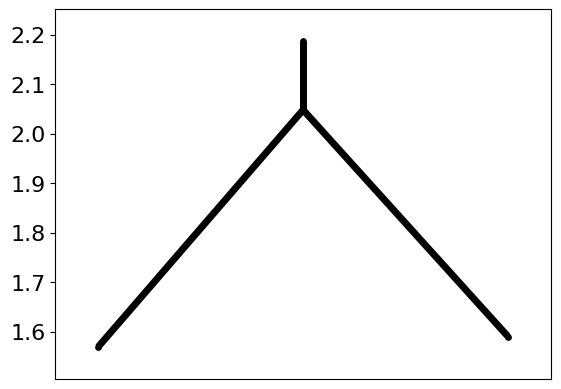

In [105]:
deviation_values_sampled = np.array([
np.sum([min(np.abs(sampled_angles[j] - angles[i]), 2 * np.pi - np.abs(sampled_angles[j] - angles[i])) ** 2 * 1/n_samples 
        for j in range(len(sampled_angles))]) ** (1/2) 
for i in range(len(angles))])
f = {i:deviation_values_sampled[i] for i in range(len(angles))}

T= simplify_merge_tree(get_merge_tree(G,f))

height = {node:T.nodes[node]['height'] for node in T.nodes()}
pos = mergeTree_pos(T,height)

nx.draw_networkx(T, pos=pos, with_labels=False,node_size = 15, node_color = 'black',width = 5)
plt.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False, labelsize = 16)
plt.savefig('CircleMergeTree.png',format='png',dpi=300)